In [1]:
# functions defined in previous notebooks
from utils import *

/Users/howardhuang/Code/my_own/DeepLearningWithPytorch-SecondEdition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor([10000.0], device=device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

In [3]:
class DenoisingModel(nn.Module):
    def __init__(self):
        super(DenoisingModel, self).__init__()
        self.time_mlp = SinusoidalEmbedding(128)
        self.pos1_mlp = SinusoidalEmbedding(128)
        self.pos2_mlp = SinusoidalEmbedding(128)

        concat_size = len(self.time_mlp) + \
            len(self.pos1_mlp) + len(self.pos2_mlp)

        hidden_size = 128
        num_layers = 3
        layers = [nn.Linear(concat_size, hidden_size), nn.ReLU()]
        for _ in range(num_layers):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.pos1_mlp(x[:, 0])
        x2_emb = self.pos2_mlp(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

In [11]:
def get_loss(model, x, t):
    x_noisy, noise = forward_diffusion_sample(x, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenoisingModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

x0 = x0.to(device)
def train(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        t = torch.randint(0, T, (x0.shape[0],)).to(device)
        optimizer.zero_grad()
        loss = get_loss(model, x0, t)
        loss.backward()
        optimizer.step()
        print(f"Finished epoch {epoch + 1}/{num_epochs}, loss: {loss.item():.4f}")

train(model, optimizer, 1)

Finished epoch 1/1, loss: 1.0119


In [20]:
train(model, optimizer, 20000)

Finished epoch 1/20000, loss: 0.7087
Finished epoch 2/20000, loss: 0.7351
Finished epoch 3/20000, loss: 0.7508
Finished epoch 4/20000, loss: 0.7162
Finished epoch 5/20000, loss: 0.7402
Finished epoch 6/20000, loss: 0.7455
Finished epoch 7/20000, loss: 0.7340
Finished epoch 8/20000, loss: 0.7244
Finished epoch 9/20000, loss: 0.7022
Finished epoch 10/20000, loss: 0.7363
Finished epoch 11/20000, loss: 0.7277
Finished epoch 12/20000, loss: 0.7408
Finished epoch 13/20000, loss: 0.7252
Finished epoch 14/20000, loss: 0.7481
Finished epoch 15/20000, loss: 0.7437
Finished epoch 16/20000, loss: 0.7195
Finished epoch 17/20000, loss: 0.7458
Finished epoch 18/20000, loss: 0.7546
Finished epoch 19/20000, loss: 0.7474
Finished epoch 20/20000, loss: 0.7382
Finished epoch 21/20000, loss: 0.7179
Finished epoch 22/20000, loss: 0.7069
Finished epoch 23/20000, loss: 0.7342
Finished epoch 24/20000, loss: 0.7410
Finished epoch 25/20000, loss: 0.7791
Finished epoch 26/20000, loss: 0.7592
Finished epoch 27/200

In [28]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

@torch.no_grad()
def sample_timestep(x, t):
    betas_t = reshape_for_x(betas[t], x)
    sqrt_one_minus_alphas_cumprod_t = reshape_for_x(sqrt_one_minus_alphas_cumprod[t], x)
    sqrt_recip_alphas_t = reshape_for_x(sqrt_recip_alphas[t], x)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = reshape_for_x(posterior_variance[t], x)
    
    if t[0] == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

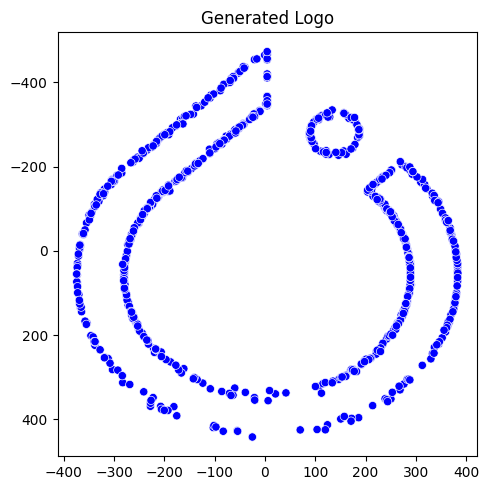

In [29]:
eval_batch_size = 800
sample = torch.randn(eval_batch_size, 2, device=device)
example_times = [999, 800, 500, 400, 0]
example_points = []
for i in range(0,T)[::-1]:
    t = torch.full((eval_batch_size,), i, dtype=torch.long, device=device)
    sample = sample_timestep(sample, t)
    if i in example_times:
        example_points.append(sample.clone())
plot_points(sample, ["Generated Logo"])

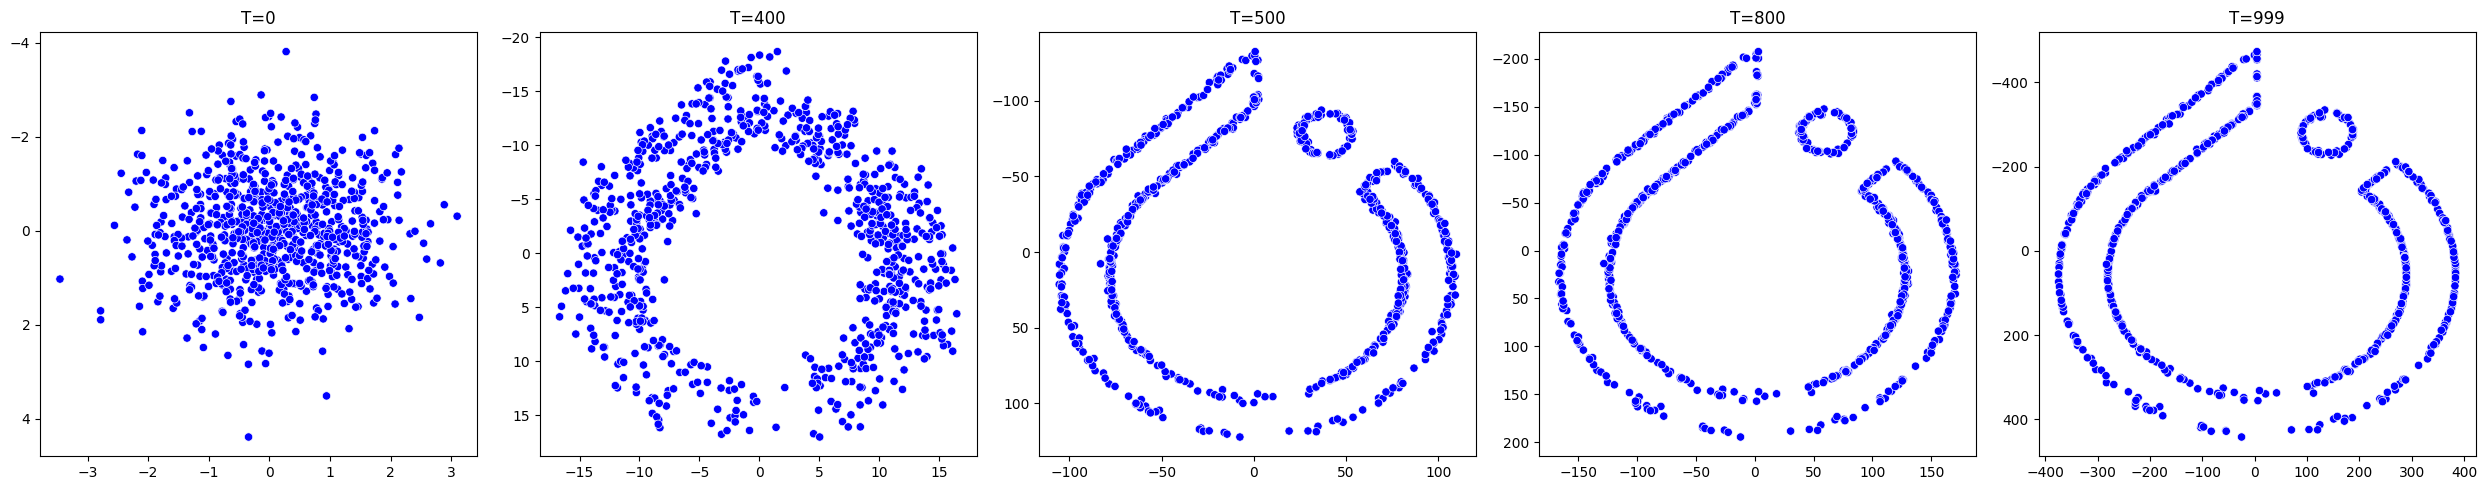

In [30]:
plot_points(example_points, ["T=0", "T=400", "T=500", "T=800", "T=999"])